In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

In [4]:
train_load_data = pd.read_csv('./data/preprocessed_train_load_data.csv')
temp_data = pd.read_csv('./data/temperature_history.csv')

In [5]:
# temp 
train_temp_data = temp_data.loc[~temp_data['h7'].isna()]
test_temp_data = temp_data.loc[temp_data['h7'].isna()]

# approach for grouping temp to load history

- do it by date first -> might not be feasable if dates are not unique
    - to try and fix this we can make some assumption based the station

In [6]:
date_cols_list = ['year', 'month', 'day']
train_temp_data['datetime'] = pd.to_datetime(train_temp_data[date_cols_list])
train_temp_data['weekday'] = train_temp_data['datetime'].dt.dayofweek
train_temp_data['week_of_year'] = train_temp_data['datetime'].dt.weekofyear
train_temp_data['day_of_year'] = train_temp_data['datetime'].dt.dayofyear
train_temp_data['is_month_start'] = (train_temp_data['datetime'].dt.is_month_start).astype(int) 
train_temp_data['is_month_end'] = (train_temp_data['datetime'].dt.is_month_end).astype(int) 

c:\users\faroo\documents\kaggle_project\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\faroo\documents\kaggle_project\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\faroo\documents\kaggle_project\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [7]:
train_temp_data['datetime'].value_counts().head()

2008-02-04    11
2006-04-17    11
2004-06-17    11
2005-08-08    11
2007-11-20    11
Name: datetime, dtype: int64

In [8]:
# rename hour cols for concatenation
hours = [f'h{hour}' for hour in range(1,24+1)]
load_hour_rename = [f'load_h{hour}' for hour in range(1,24+1)]
temp_hour_rename = [f'temp_h{hour}' for hour in range(1,24+1)]
load_columns_rename_dict = {}
for hour, rename in zip(hours, load_hour_rename): 
    load_columns_rename_dict[hour] = rename
    
temp_columns_rename_dict = {}
for hour, rename in zip(hours, temp_hour_rename): 
    temp_columns_rename_dict[hour] = rename
    
train_load_data = train_load_data.rename(columns=load_columns_rename_dict)
train_temp_data = train_temp_data.rename(columns=temp_columns_rename_dict)

In [9]:
train_load_data.head()

,zone_id,year,month,day,load_h1,load_h2,load_h3,load_h4,load_h5,load_h6,...,load_h24,datetime,weekday,week_of_year,day_of_year,is_month_start,is_month_end,hour_sum,hour_mean,hour_median
0,1,2004,1,1,16853.0,16450.0,16517.0,16873.0,17064.0,17727.0,...,14750.0,2004-01-01,3,1,1,1,0,400880.0,16703.333333,16863.0
1,1,2004,1,2,14155.0,14038.0,14019.0,14489.0,14920.0,16072.0,...,15258.0,2004-01-02,4,1,2,0,0,408157.0,17006.541667,17313.0
2,1,2004,1,3,14439.0,14272.0,14109.0,14081.0,14775.0,15491.0,...,12424.0,2004-01-03,5,1,3,0,0,366696.0,15279.000000,14876.5
3,1,2004,1,4,11273.0,10415.0,9943.0,9859.0,9881.0,10248.0,...,11727.0,2004-01-04,6,1,4,0,0,325465.0,13561.041667,14184.5
4,1,2004,1,5,10750.0,10321.0,10107.0,10065.0,10419.0,12101.0,...,16018.0,2004-01-05,0,2,5,0,0,347519.0,14479.958333,14188.5


In [10]:
train_load_data['zone_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [11]:
train_temp_data.head()

,station_id,year,month,day,temp_h1,temp_h2,temp_h3,temp_h4,temp_h5,temp_h6,...,temp_h21,temp_h22,temp_h23,temp_h24,datetime,weekday,week_of_year,day_of_year,is_month_start,is_month_end
0,1,2004,1,1,46,46,45,41,39,35,...,39.0,38.0,40.0,41.0,2004-01-01,3,1,1,1,0
1,1,2004,1,2,43,44,46,46,47,47,...,46.0,45.0,45.0,45.0,2004-01-02,4,1,2,0,0
2,1,2004,1,3,45,46,46,44,43,46,...,62.0,63.0,63.0,62.0,2004-01-03,5,1,3,0,0
3,1,2004,1,4,63,62,62,62,60,60,...,65.0,64.0,65.0,64.0,2004-01-04,6,1,4,0,0
4,1,2004,1,5,64,63,65,64,64,64,...,52.0,49.0,47.0,47.0,2004-01-05,0,2,5,0,0


In [13]:
train_temp_data['station_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

# Distribution of Temp Data

In [17]:
save_figures = True

In [18]:
def create_dir(file_path):
    directory = os.path.dirname(file_path)
    print(os.listdir('.'))
    if not os.path.exists(directory):
        os.makedirs(directory)
        print('dir for graphs made')
    else: 
        print("dir already exists")
        
graphs_file_path = './graphs'
create_dir(graphs_file_path)

['.ipynb_checkpoints', 'data', 'graphs', 'keras_training.ipynb', 'model_analysis_load_only.ipynb', 'visualization_preprocessing_load_temp_hist.ipynb', 'visualization_preprocess_load_history.ipynb']
dir already exists


In [88]:
train_temp_data.shape[0]

18062

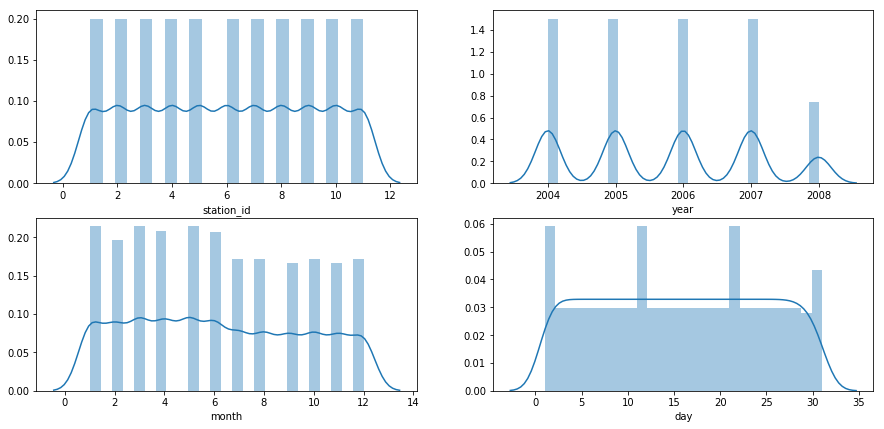

In [31]:
fig, axes = plt.subplots(2,2, figsize=(15,7))

sns.distplot(train_temp_data['station_id'], ax=axes[0,0])
sns.distplot(train_temp_data['year'], ax=axes[0,1])
sns.distplot(train_temp_data['month'], ax=axes[1,0])
sns.distplot(train_temp_data['day'], ax=axes[1,1])

if save_figures:
    fig.savefig(f'{graphs_file_path}/distribution_of_temp_data.png')

### trends 
- should be the same at the load history data because we want temp to be one to one on the number of days

# compare zone_id with station_id

In [28]:
# zone_id of 4, 8 and 5 are excluded
excluded_zone_dt = train_load_data.loc[train_load_data['zone_id']!=4]
excluded_zone_dt = excluded_zone_dt.loc[train_load_data['zone_id']!=5]
excluded_zone_dt = excluded_zone_dt.loc[train_load_data['zone_id']!=8]

In [29]:
excluded_zone_dt['zone_id'].unique()

array([ 1,  2,  3,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
      dtype=int64)

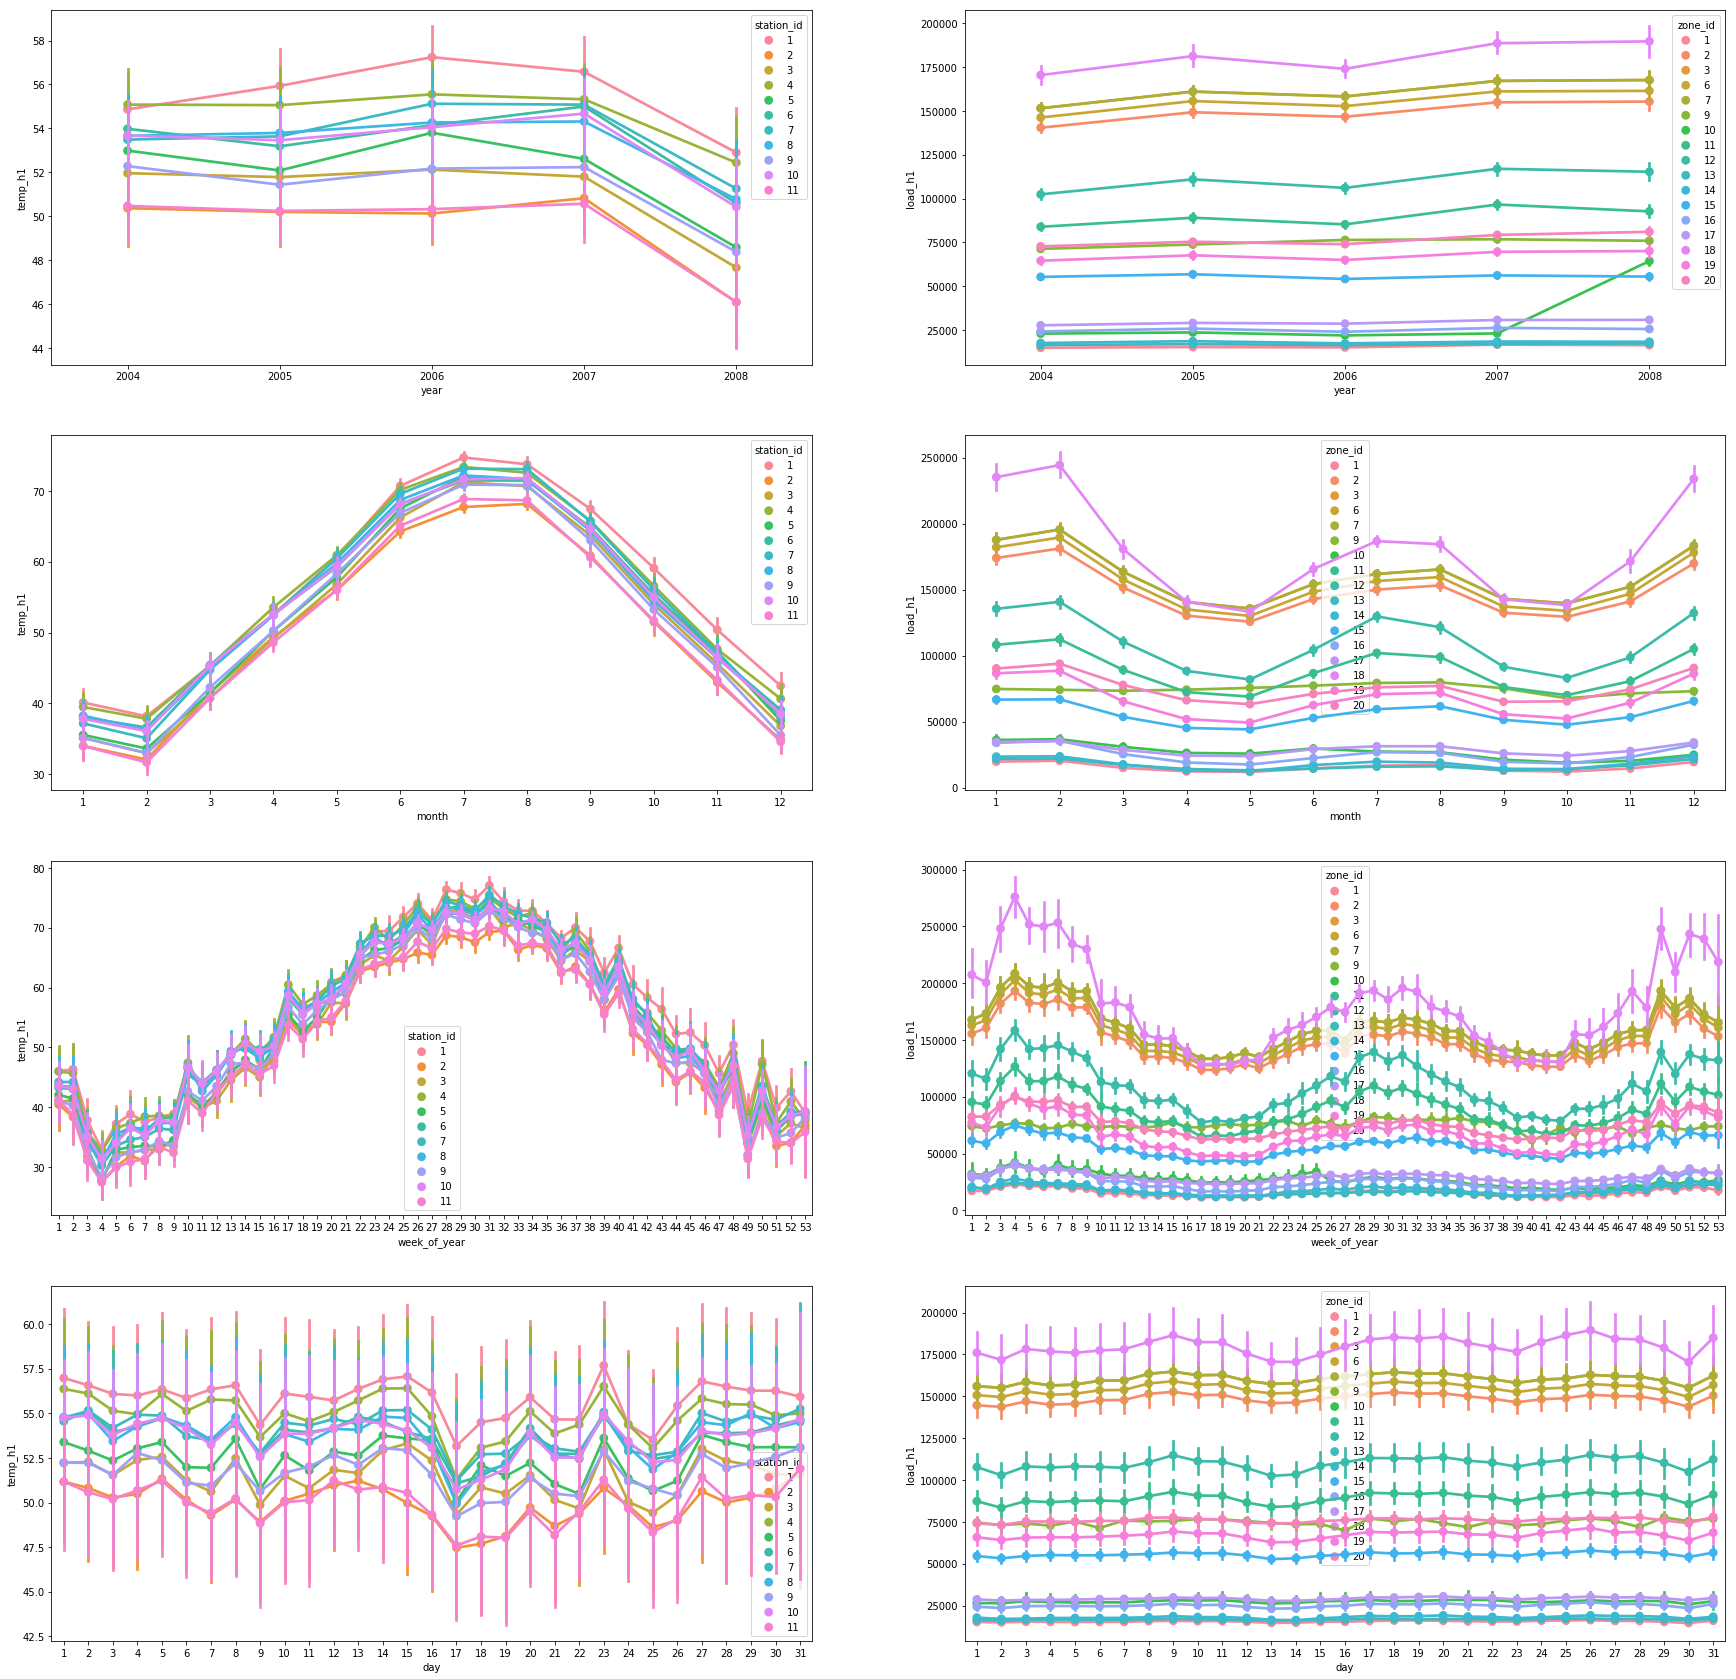

In [35]:
fig, axes = plt.subplots(4,2, figsize=(30,30))

sns.pointplot(x='year', y='temp_h1', hue="station_id",  err_style=None, data=train_temp_data, ax=axes[0,0])
sns.pointplot(x='year', y='load_h1', hue="zone_id",  err_style=None, data=excluded_zone_dt, ax=axes[0,1])

sns.pointplot(x='month', y='temp_h1', hue="station_id",  err_style=None, data=train_temp_data, ax=axes[1,0])
sns.pointplot(x='month', y='load_h1', hue="zone_id",  err_style=None, data=excluded_zone_dt, ax=axes[1,1])

sns.pointplot(x='week_of_year', y='temp_h1', hue="station_id",  err_style=None, data=train_temp_data, ax=axes[2,0])
sns.pointplot(x='week_of_year', y='load_h1', hue="zone_id",  err_style=None, data=excluded_zone_dt, ax=axes[2,1])

sns.pointplot(x='day', y='temp_h1', hue="station_id",  err_style=None, data=train_temp_data, ax=axes[3,0])
sns.pointplot(x='day', y='load_h1', hue="zone_id",  err_style=None, data=excluded_zone_dt, ax=axes[3,1])

if save_figures:
    fig.savefig(f'{graphs_file_path}/hour1_station_zone_comparison.png')

### compare i'th station with j'th zone for k'th hour

In [33]:
specific_station_dt = train_temp_data.loc[train_temp_data['station_id']==1]
specific_zone_dt = train_load_data.loc[train_load_data['zone_id']==1]

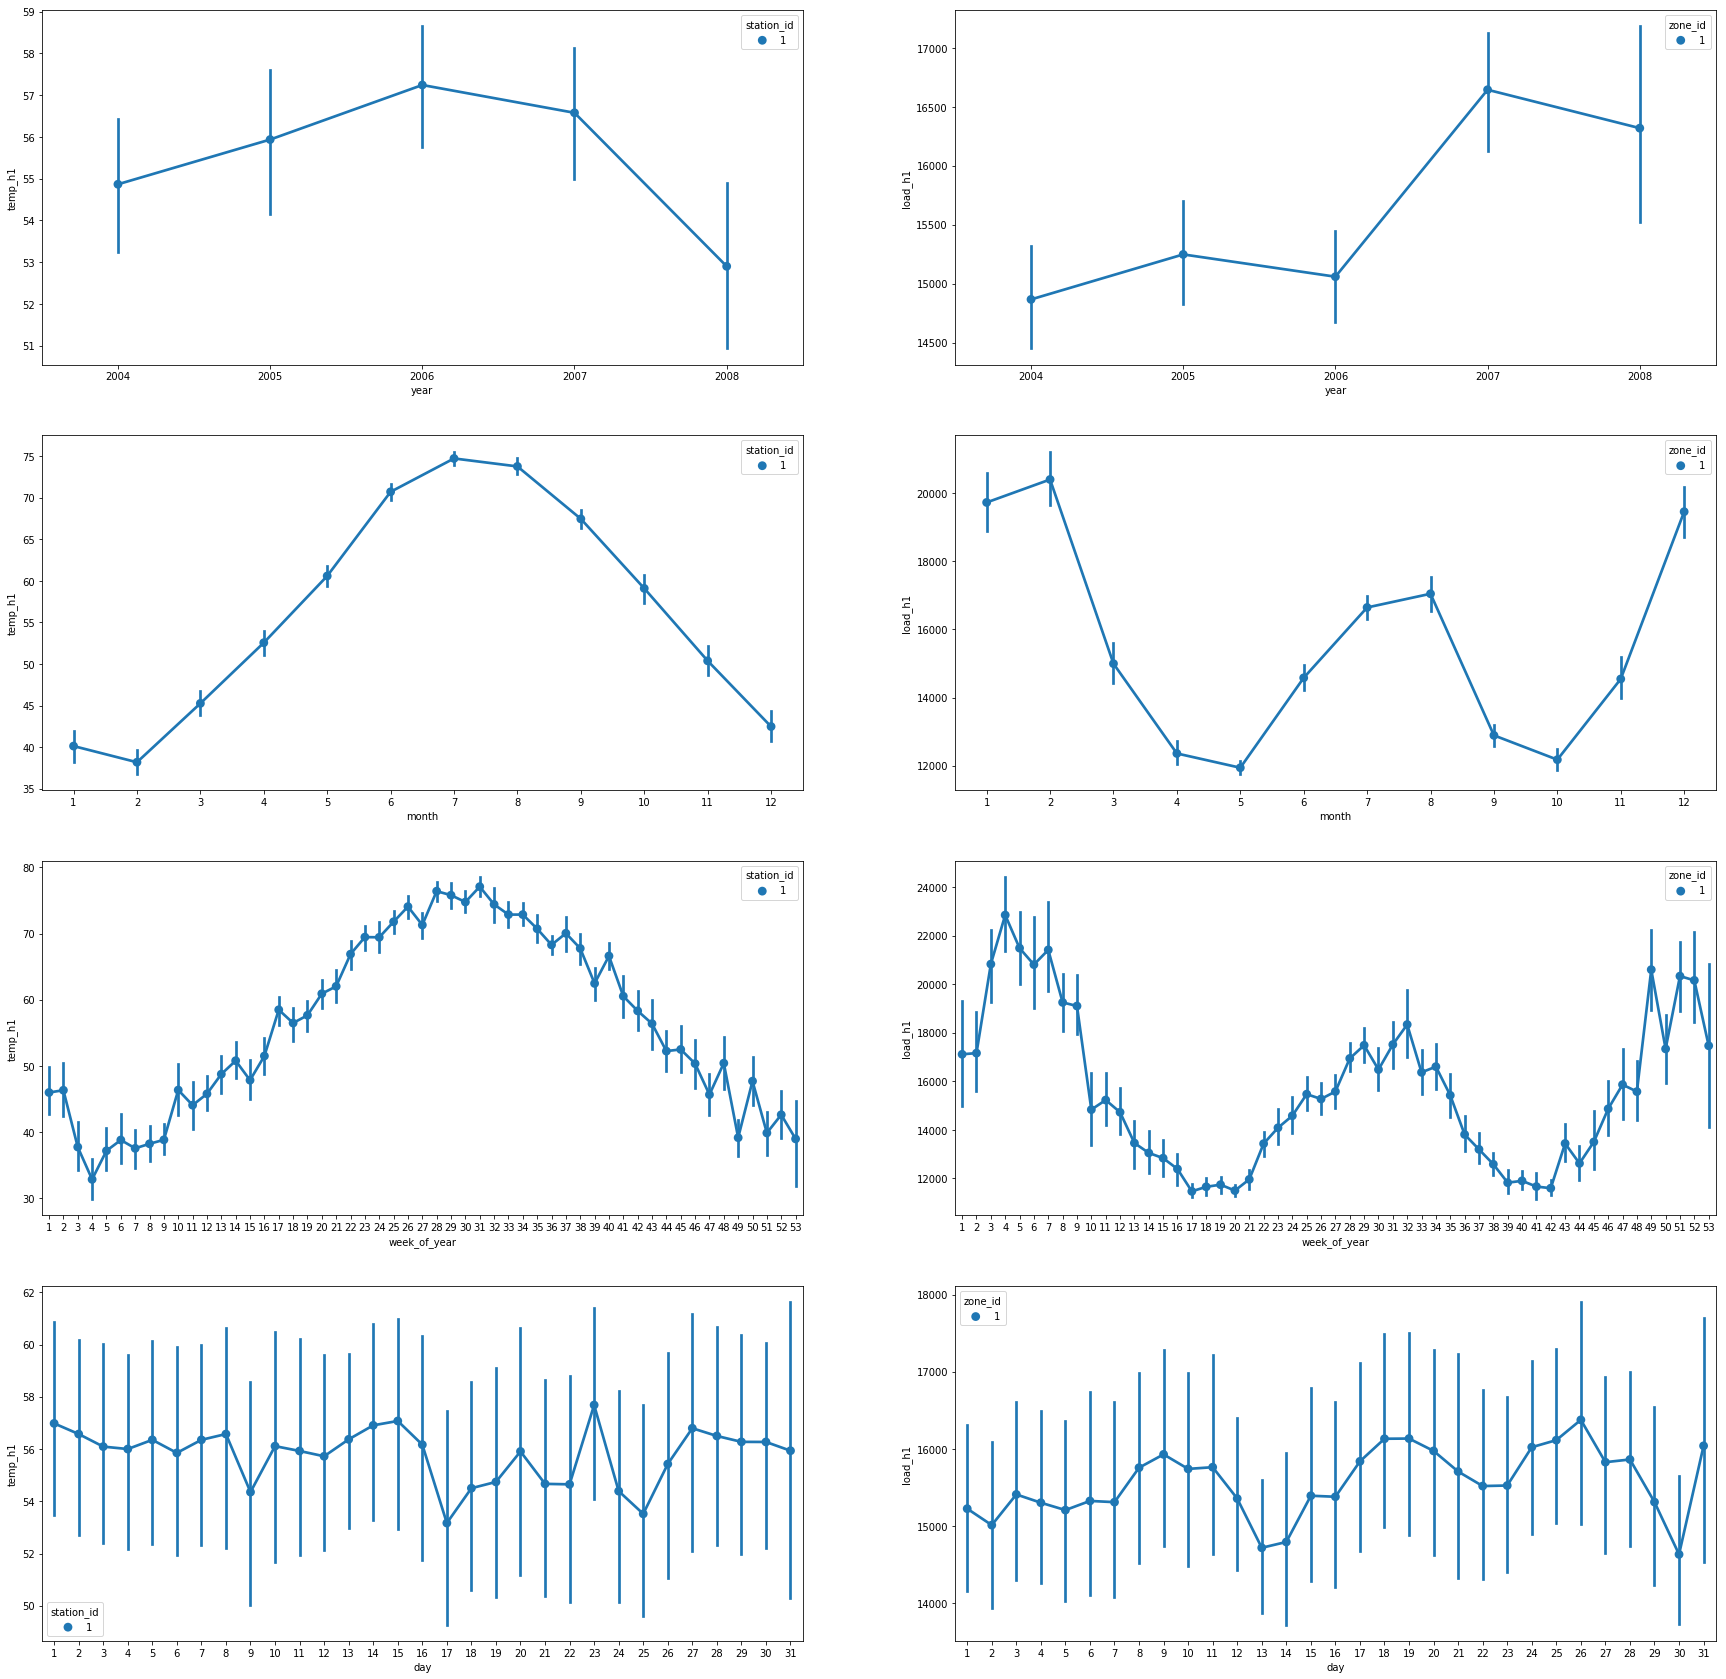

In [37]:
fig, axes = plt.subplots(4,2, figsize=(30,30))

sns.pointplot(x='year', y='temp_h1', hue="station_id", data=specific_station_dt, ax=axes[0,0])
sns.pointplot(x='year', y='load_h1', hue="zone_id",  err_style=None, data=specific_zone_dt, ax=axes[0,1])

sns.pointplot(x='month', y='temp_h1', hue="station_id",  err_style=None, data=specific_station_dt, ax=axes[1,0])
sns.pointplot(x='month', y='load_h1', hue="zone_id",  err_style=None, data=specific_zone_dt, ax=axes[1,1])

sns.pointplot(x='week_of_year', y='temp_h1', hue="station_id",  err_style=None, data=specific_station_dt, ax=axes[2,0])
sns.pointplot(x='week_of_year', y='load_h1', hue="zone_id",  err_style=None, data=specific_zone_dt, ax=axes[2,1])

sns.pointplot(x='day', y='temp_h1', hue="station_id",  err_style=None, data=specific_station_dt, ax=axes[3,0])
sns.pointplot(x='day', y='load_h1', hue="zone_id",  err_style=None, data=specific_zone_dt, ax=axes[3,1])

if save_figures:
    fig.savefig(f'{graphs_file_path}/zone1_station1_hour1_year_month_weekofyear_day.png')

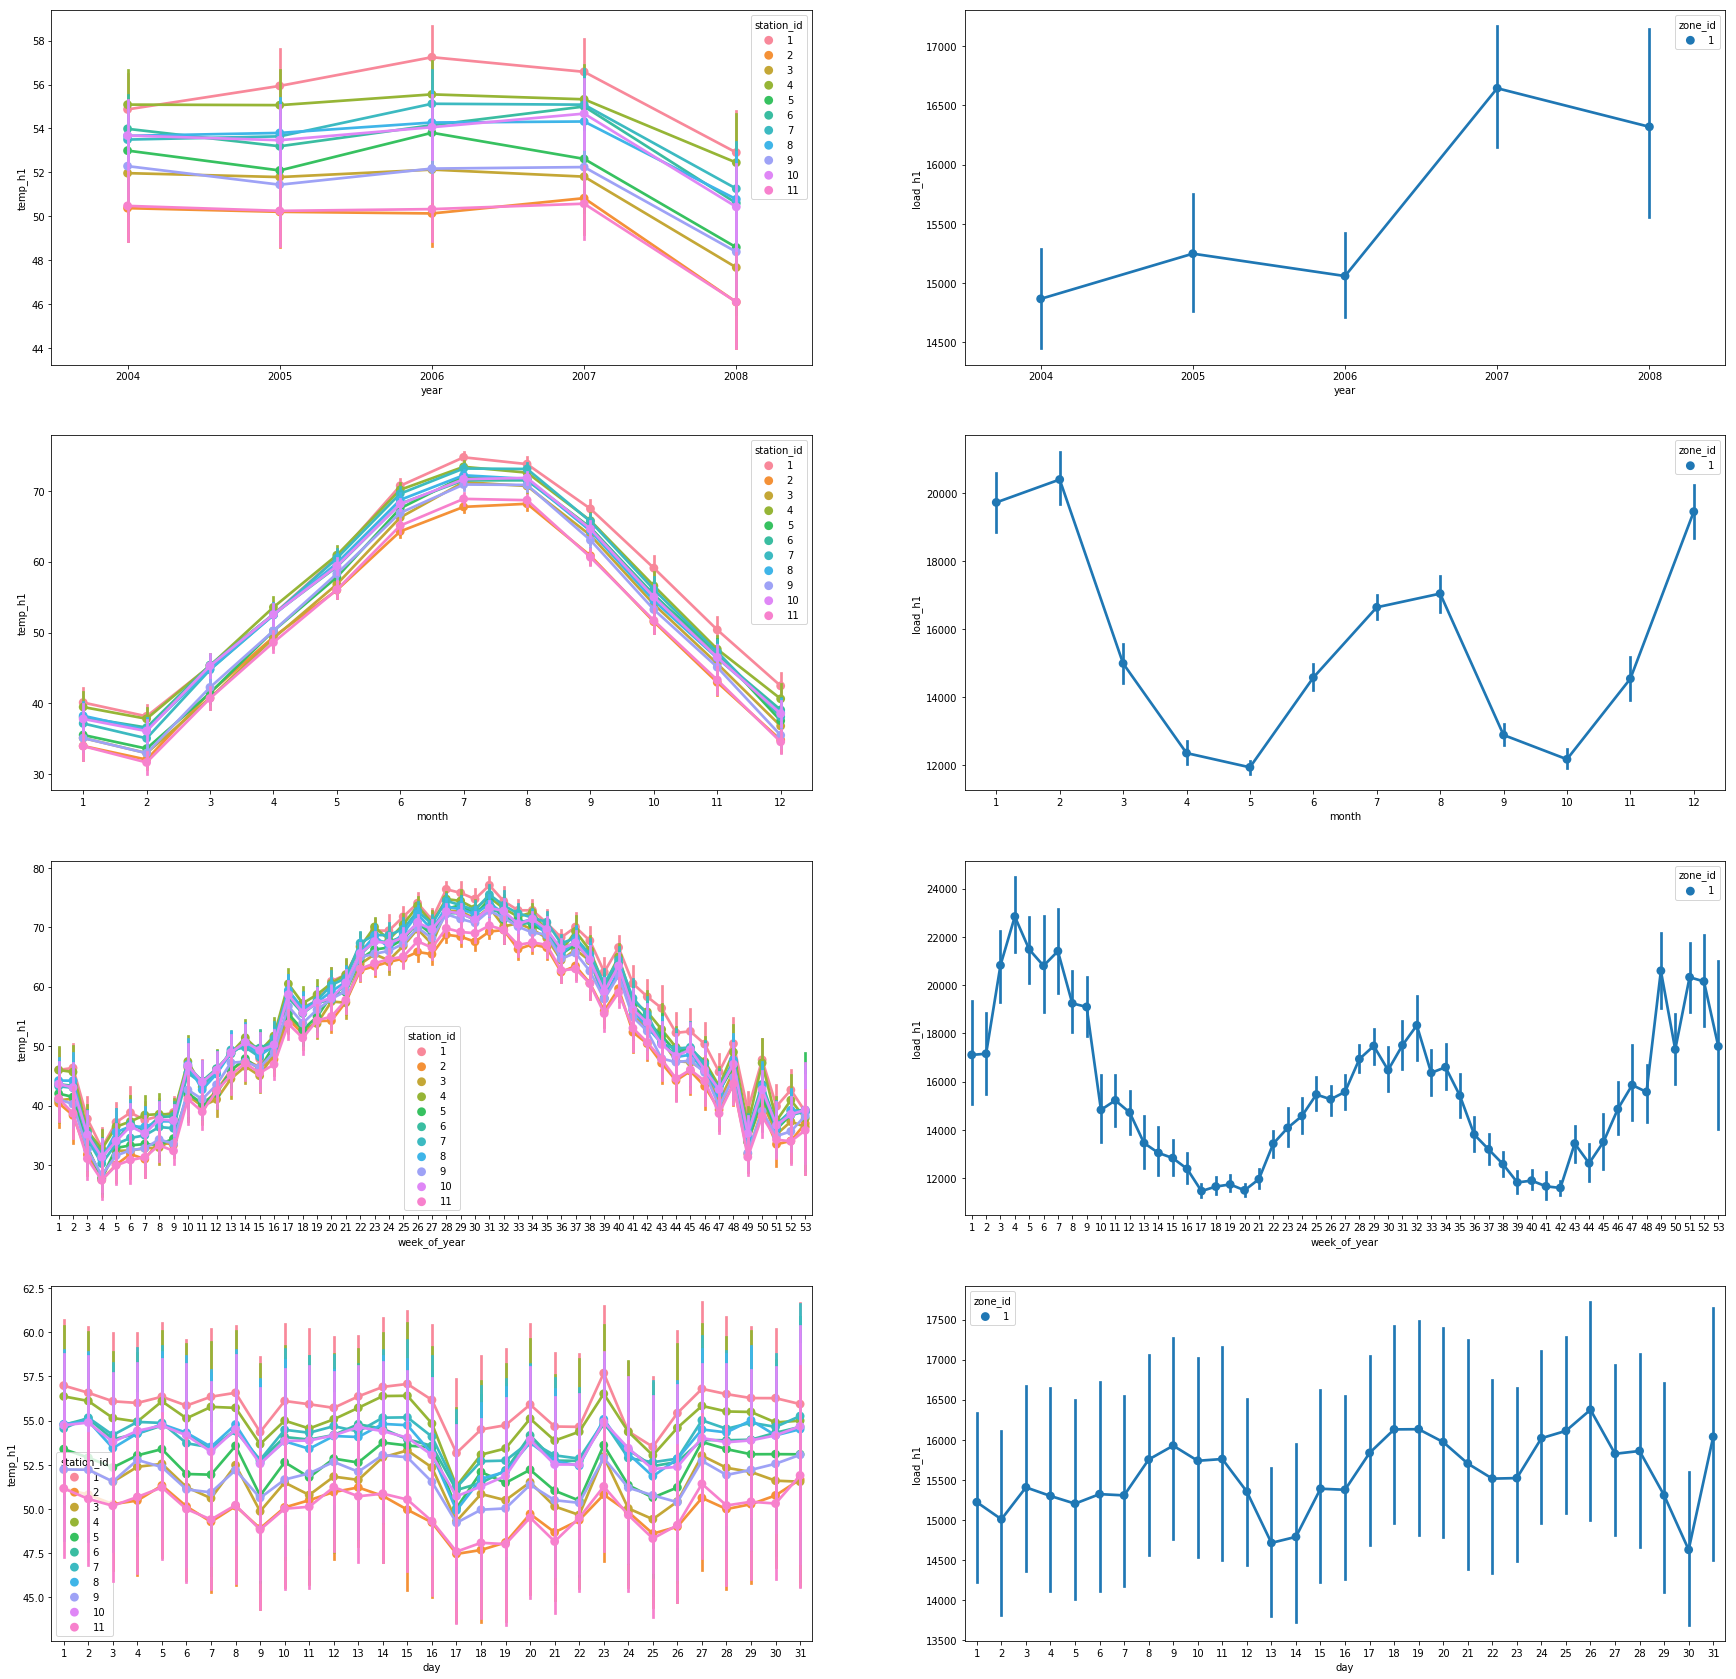

In [38]:
fig, axes = plt.subplots(4,2, figsize=(30,30))

sns.pointplot(x='year', y='temp_h1', hue="station_id", data=train_temp_data, ax=axes[0,0])
sns.pointplot(x='year', y='load_h1', hue="zone_id",  err_style=None, data=specific_zone_dt, ax=axes[0,1])

sns.pointplot(x='month', y='temp_h1', hue="station_id",  err_style=None, data=train_temp_data, ax=axes[1,0])
sns.pointplot(x='month', y='load_h1', hue="zone_id",  err_style=None, data=specific_zone_dt, ax=axes[1,1])

sns.pointplot(x='week_of_year', y='temp_h1', hue="station_id",  err_style=None, data=train_temp_data, ax=axes[2,0])
sns.pointplot(x='week_of_year', y='load_h1', hue="zone_id",  err_style=None, data=specific_zone_dt, ax=axes[2,1])

sns.pointplot(x='day', y='temp_h1', hue="station_id",  err_style=None, data=train_temp_data, ax=axes[3,0])
sns.pointplot(x='day', y='load_h1', hue="zone_id",  err_style=None, data=specific_zone_dt, ax=axes[3,1])


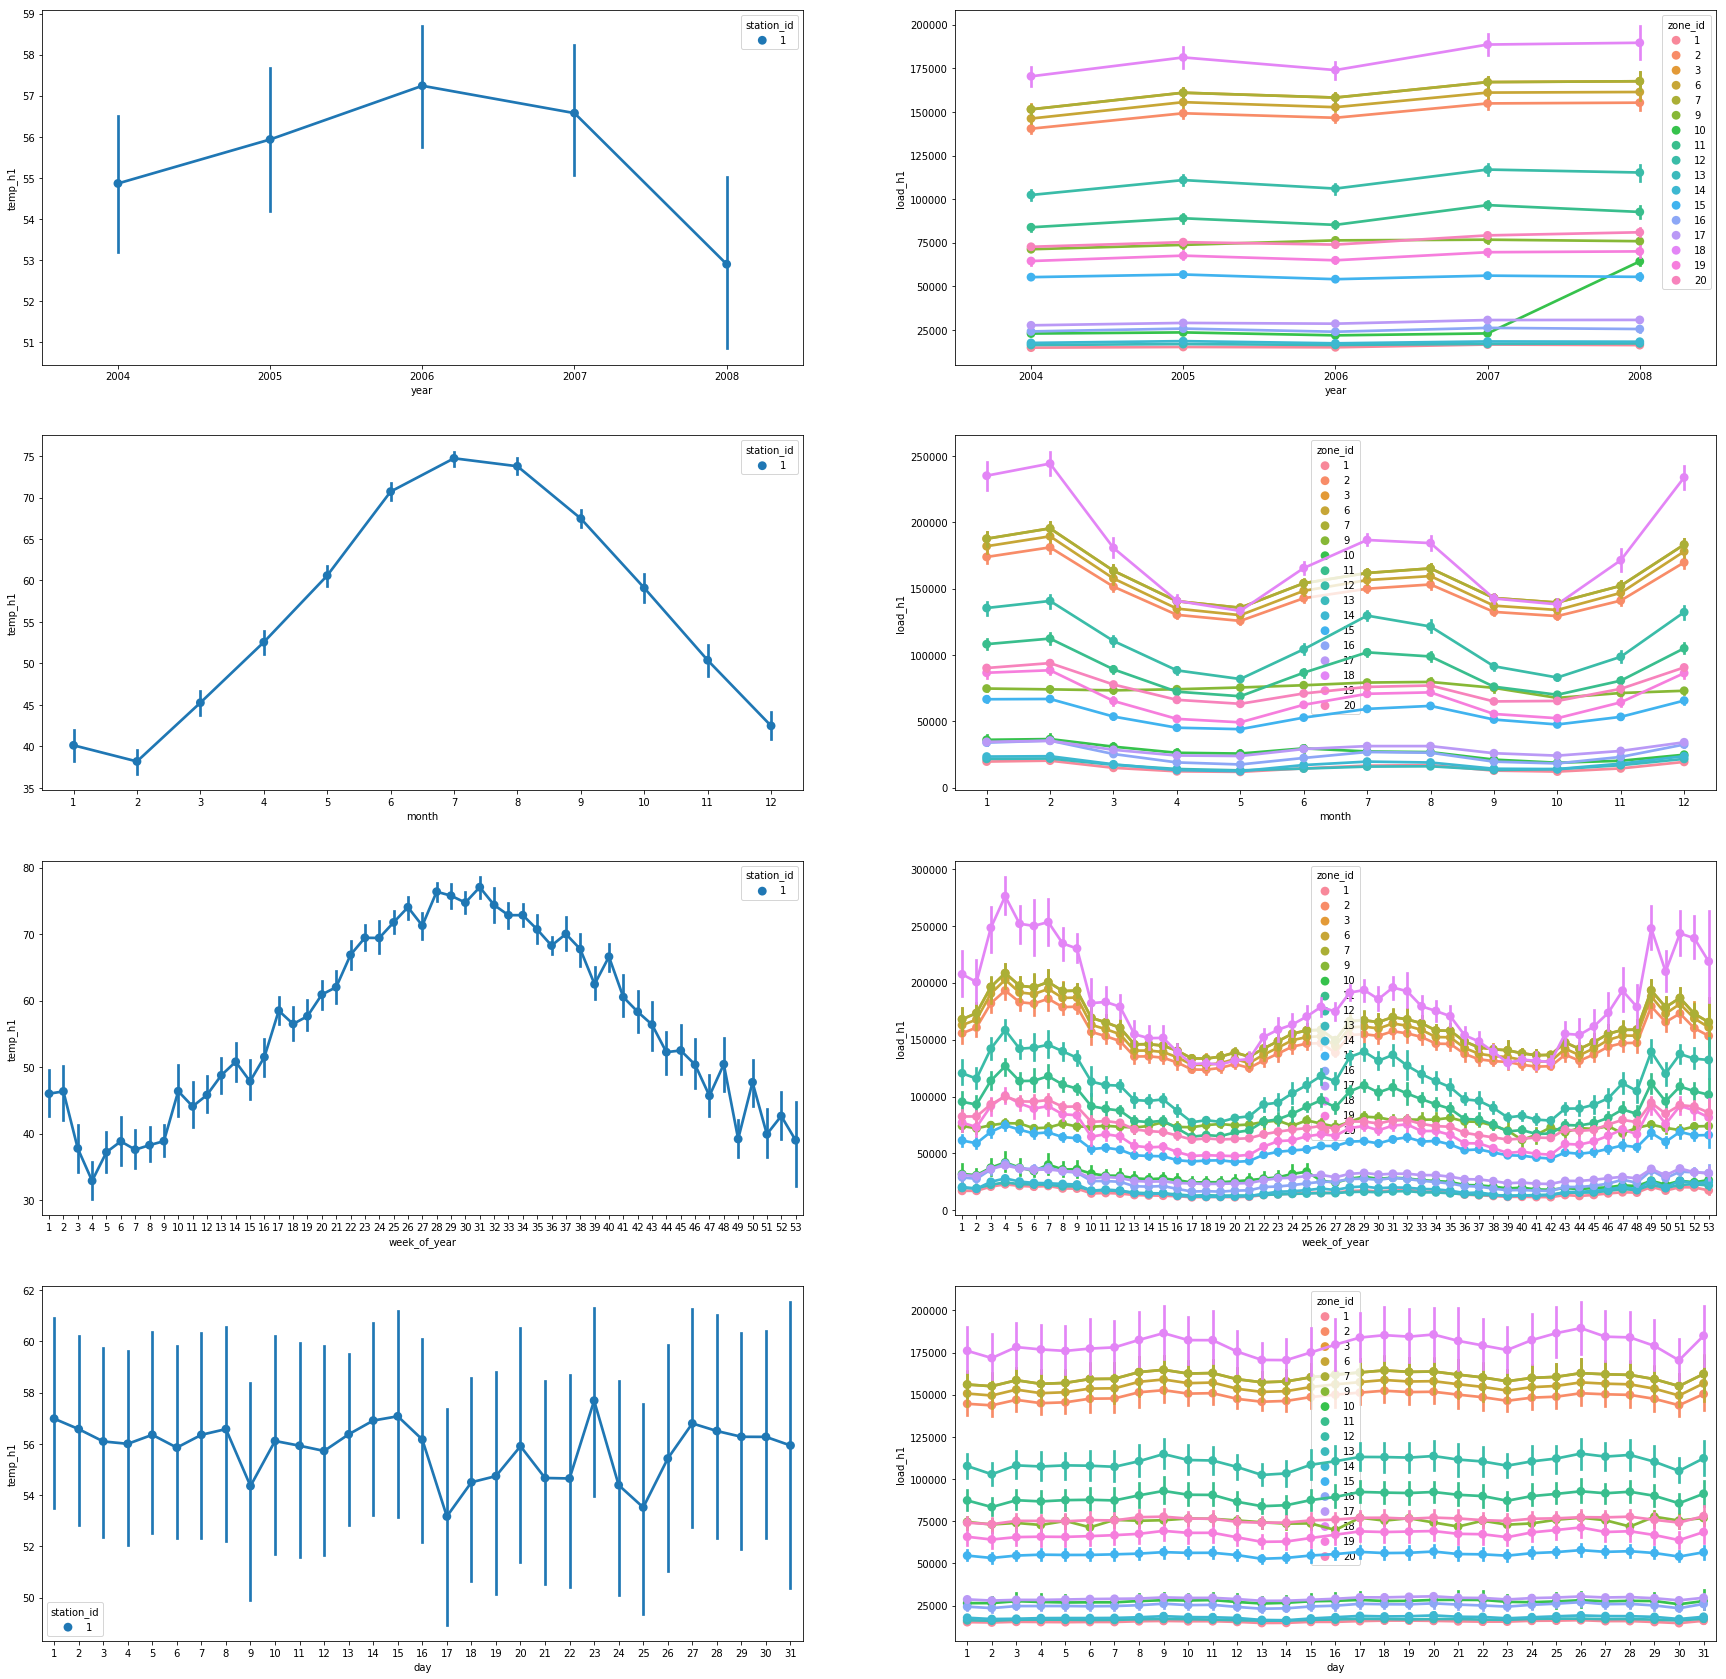

In [39]:
fig, axes = plt.subplots(4,2, figsize=(30,30))

sns.pointplot(x='year', y='temp_h1', hue="station_id", data=specific_station_dt, ax=axes[0,0])
sns.pointplot(x='year', y='load_h1', hue="zone_id",  err_style=None, data=excluded_zone_dt, ax=axes[0,1])

sns.pointplot(x='month', y='temp_h1', hue="station_id",  err_style=None, data=specific_station_dt, ax=axes[1,0])
sns.pointplot(x='month', y='load_h1', hue="zone_id",  err_style=None, data=excluded_zone_dt, ax=axes[1,1])

sns.pointplot(x='week_of_year', y='temp_h1', hue="station_id",  err_style=None, data=specific_station_dt, ax=axes[2,0])
sns.pointplot(x='week_of_year', y='load_h1', hue="zone_id",  err_style=None, data=excluded_zone_dt, ax=axes[2,1])

sns.pointplot(x='day', y='temp_h1', hue="station_id",  err_style=None, data=specific_station_dt, ax=axes[3,0])
sns.pointplot(x='day', y='load_h1', hue="zone_id",  err_style=None, data=excluded_zone_dt, ax=axes[3,1])

# Combine load and temp data based on only one station

In [ ]:
# cols_to_view = ['year', 'month', 'day', 'datetime', 'zone_id', 'station_id']

# # add temp hour data to train_laod_data based on same datetime
# load_row_index = 0
# temp_row_index = 0
# for load_row_index in train_loap_data.shape[0]:
#     for temp_row_index in train_temp_data.shape[0]:
#     if train_load_data.loc[load_row_index, 'datetime'] == train_temp_data.loc[temp_row_index, 'datetime']:
        
#         train_temp_data.loc[0, temp_hour_rename]
        

# train_temp_data['datetime'][0] == train_load_data['datetime'][0]